## Camera calibration

20


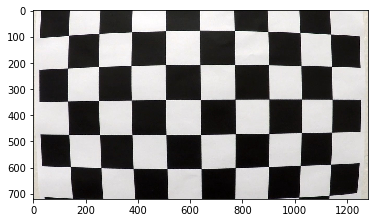

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
#Read in camera calibration images 
calib_images = []
for i in range(1,21):
    image_name = "./camera_cal/calibration" + str(i) + ".jpg"
    calib_images.append(mpimg.imread(image_name))
print(len(calib_images))
plt.imshow(calib_images[0])

17
17


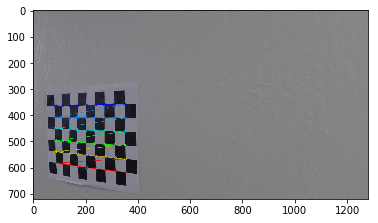

In [2]:
# Find chessboard corners for calibration

nx = 9
ny = 6
#create object points
objpoints = []
imgpoints = []
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for i in range(1,21):
    image_name = "./camera_cal/calibration" + str(i) + ".jpg"
    img = mpimg.imread(image_name)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        img1 = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img1)

## Obtain undistorted images from calibrated parameters

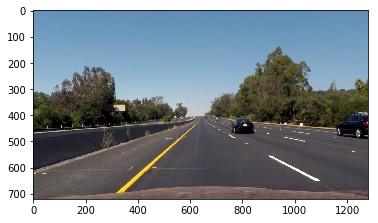

In [14]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
for i in range(1,1261):
    image_name = "./video/project_%04d"%i
    image_name = image_name + ".jpg"
    #image_name = "camera_cal/calibration" + str(i) + ".jpg"
    img = mpimg.imread(image_name)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_out_name = "./undistorted_project/undistorted_%04d"%i
    image_out_name = image_out_name + ".jpg"
    plt.imsave(image_out_name, np.array(dst).reshape(dst.shape[0],dst.shape[1],3))
plt.imshow(dst)

## Various operators used for thresholding

In [7]:
# Apply sobel operator
def abs_sobel_thresh(img, orient='x', sobel_kernel=3,thresh=(0,255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #binary_output = np.copy(img) # Remove this line
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

In [335]:
def find_lanes(image):
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.uint8([0, 200,0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return mask

### Perspective transform

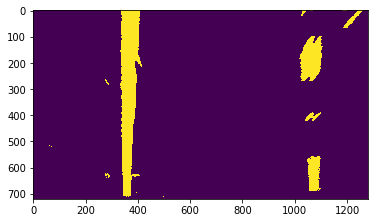

In [276]:
### STORE PERSPECTIVE TRANSFORMED BINARY WARPED IMAGES
import matplotlib.cm as cm
for i in range(1,1261):
    image_name = "./undistorted_project/undistorted_%04d"%i
    image_name = image_name + ".jpg"
    image = mpimg.imread(image_name)
    ksize = 15
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 120))
    masked = find_lanes(image)
    combined = np.zeros_like(masked)
    combined[(masked > 0) | (gradx == 1)] =1
    image1 = combined
    src = np.float32([(200, 720), (580, 480), (720, 480), (1050, 700)])
    dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)])
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (image1.shape[1],image1.shape[0])
    warped = cv2.warpPerspective(image1, M, img_size)
    image_out_name = "./warp_HLS/binary_warped_%04d"%i
    image_out_name = image_out_name + ".png"
plt.imshow(warped)

## Threshold on test images

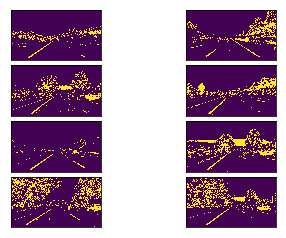

In [353]:
def apply_threshold(image):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 120))
    masked = find_lanes(image)
    combined = np.zeros_like(masked)
    combined[(masked > 0) | (gradx == 1)] =1
    return combined

import glob
test_images = glob.glob('./test_images/*.jpg')
fig, axes = plt.subplots(4, 2)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, ax in enumerate(axes.flat):
    #i = random.randint(0, len(color_X_train)) 
    image = mpimg.imread(test_images[i])
    #image = image.squeeze()#.reshape(img_shape)            
    binary = apply_threshold(image)
    img_out = "./test_images_output/test_%04d"%i
    img_out = img_out + ".jpg"
    plt.imsave(img_out, np.array(binary).reshape(binary.shape[0],binary.shape[1]))
    ax.imshow(binary)
    ax.set_xticks([])
    ax.set_yticks([])

## Sliding window to detect lane lines

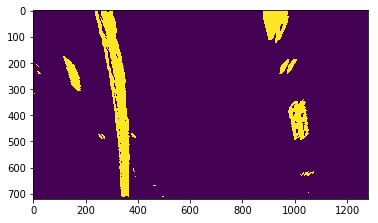

In [295]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#binary_warped = mpimg.imread("/Users/vikramnagashoka/SDC/CarND-Advanced-Lane-Lines/binary/binary_warped_0005.png")
previous_left = np.empty(10,dtype=np.ndarray)
previous_right = np.empty(10,dtype=np.ndarray)

for i in range(1,11):
    img_name = "./warp_HLS/binary_warped_%04d"%i
    img_name = img_name + ".png"
    binary_warped = cv2.imread(img_name,0)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(int(win_xleft_low),int(win_y_low)),(int(win_xleft_high),int(win_y_high)),(0,255,0), 2) 
        cv2.rectangle(out_img,(int(win_xright_low),int(win_y_low)),(int(win_xright_high),int(win_y_high)),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #Save points from last 10 frames for further use
    previous_left[(i%10)-1] = left_fitx
    previous_right[(i%10)-1] = right_fitx
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

(720, 0)

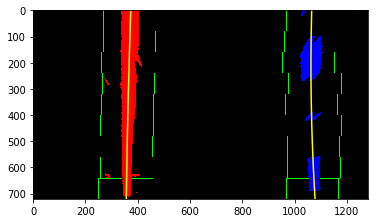

In [279]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
left_pts = np.column_stack((left_fitx,ploty))
right_pts = np.column_stack((right_fitx,ploty))
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### AFTER FINDING LANE LINES
#### Pipeline applied on whole video

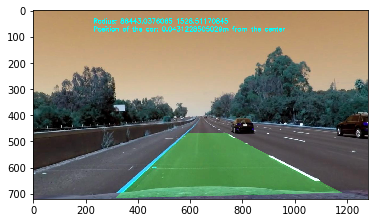

In [333]:

src = np.float32([(200, 720), (580, 480), (720, 480), (1050, 700)])
dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)])
Minv = cv2.getPerspectiveTransform(dst, src)
font = cv2.FONT_HERSHEY_SIMPLEX
for i in range(1,1261):
    img_name = "./warp_HLS/binary_warped_%04d"%i
    img_name = img_name + ".png"
    binary_warped = cv2.imread(img_name,0)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    previous_left[(i%10)-1] = left_fitx
    previous_right[(i%10)-1] = right_fitx
    left_fitx = np.mean(previous_left)
    right_fitx = np.mean(previous_right)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    img_out = "./poly/poly_%04d"%i
    img_out = img_out + ".png"
    ## Draw on original
    image_name = "./undistorted_project/undistorted_%04d"%i
    image_name = image_name + ".jpg"
    undist = cv2.imread(image_name)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    results = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    ##Calculate radius of curvature
    ploty = np.linspace(0, 719, num=len(leftx))
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    ploty = np.linspace(0, 719, num=len(rightx))
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    cv2.putText(results, "Radius: "+str(left_curverad) + " " + str(right_curverad), (230, 50), font, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    offset = np.abs(lane_center - binary_warped.shape[1]/2)
    offset = offset * (3.7/7000) # Converting to metres
    cv2.putText(results,"Position of the car: " + str(offset) + "m" + " from the center", (230, 80), font, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    cv2.imwrite(img_out,results)
    plt.imshow(results)

## Fill polygon over the detected lane lines

(720, 0)

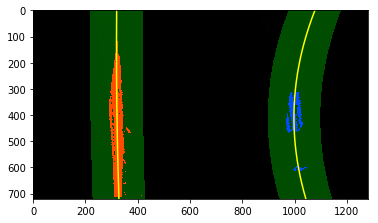

In [285]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)